# Variability analysis for HBEC IFN experiment

In [6]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [7]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [8]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

In [9]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [10]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [11]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [12]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [13]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
adata.shape

(69958, 36588)

### Finding examples of simple regulation

In [15]:
adata

AnnData object with n_obs × n_vars = 69958 × 36588
    obs: 'NUM.SNPS', 'BEST.GUESS', 'DROPLET.TYPE', 'batch', 'HTO_classification', 'condition', 'donor', 'stim', 'time', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
stim = 'gamma'
ct = ['ciliated']
subset_processed = adata[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim])].copy()


In [409]:
# sc.pp.normalize_total(subset_processed, target_sum=1e4)

In [17]:
sc.pp.log1p(subset_processed)

In [18]:
df = pd.DataFrame()
df['STAT1'] = subset_processed[:, 'STAT1'].X.todense().A1
df['STAT2'] = subset_processed[:, 'STAT2'].X.todense().A1
df['IRF9'] = subset_processed[:, 'IRF9'].X.todense().A1

df['GBP1'] = subset_processed[:, 'GBP1'].X.todense().A1
df['ACTB'] = subset_processed[:, 'ACTB'].X.todense().A1

df['time'] = subset_processed.obs['time'].values

In [83]:
def row_based_idx(num_rows, num_cols, idx):
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

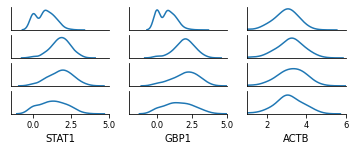

In [92]:
plt.figure(figsize=(6, 3))
idx = 1

for time in ['0', '3', '9','48']:
    plt.subplot(6, 3, row_based_idx(4, 3, idx));
    fig = sns.kdeplot(df.query('time == "{}"'.format(time)).STAT1, bw_adjust=1.5)

    sns.despine();
    if time != '48':
        plt.xticks([]);

    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([]);
    plt.xlim(-1.5, 5);
    plt.ylim(0, 0.7)
    if time == '48':
        plt.xlabel('STAT1')
    idx+=1
        
for time in ['0', '3', '9','48']:
    plt.subplot(6, 3, row_based_idx(4, 3, idx));
    fig = sns.kdeplot(df.query('time == "{}"'.format(time)).GBP1, bw_adjust=1.5)

    sns.despine();
    if time != '48':
        plt.xticks([]);

    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([]);
    plt.xlim(-2, 5);
    plt.ylim(0, 0.7)
    if time == '48':
        plt.xlabel('GBP1')
    idx+=1

for time in ['0', '3', '9','48']:
    plt.subplot(6, 3, row_based_idx(4, 3, idx));
    fig = sns.kdeplot(df.query('time == "{}"'.format(time)).ACTB, bw_adjust=1.5)

    sns.despine();
    if time != '48':
        plt.xticks([]);

    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([]);
    plt.xlim(1, 6);
    plt.ylim(0, 0.7)
    if time == '48':
        plt.xlabel('ACTB')
    idx+=1
    
plt.savefig(fig_path + 'gene_hists.pdf', bbox_inches='tight')


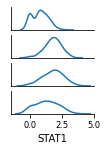

In [82]:
plt.figure(figsize=(1.5, 3))
# plt.subplots_adjust(hspace=0.005)
for idx, time in enumerate(['0', '3', '9','48']):
    plt.subplot(6, 1, idx+1);
    fig = sns.kdeplot(df.query('time == "{}"'.format(time)).STAT1, bw_adjust=1.5)

    sns.despine();
    if time != '48':
        plt.xticks([]);

    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([]);
    plt.xlim(-1.5, 5);
    plt.ylim(0, 0.7)
    if time == '48':
        plt.xlabel('STAT1')


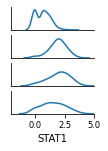

In [76]:
plt.figure(figsize=(1.5, 3))
# plt.subplots_adjust(hspace=0.005)
for idx, time in enumerate(['0', '3', '9','48']):
    plt.subplot(6, 1, idx+1);
    fig = sns.kdeplot(df.query('time == "{}"'.format(time)).GBP1, bw_adjust=1.5)

    sns.despine();
    if time != '48':
        plt.xticks([]);

    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([]);
    plt.xlim(-2, 5);
    plt.ylim(0, 0.7)
    if time == '48':
        plt.xlabel('GBP1')

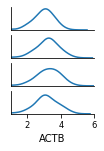

In [77]:
plt.figure(figsize=(1.5, 3))
# plt.subplots_adjust(hspace=0.005)
for idx, time in enumerate(['0', '3', '9','48']):
    plt.subplot(6, 1, idx+1);
    fig = sns.kdeplot(df.query('time == "{}"'.format(time)).ACTB, bw_adjust=1.5)

    sns.despine();
    if time != '48':
        plt.xticks([]);

    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([]);
    plt.xlim(1, 6);
    plt.ylim(0, 0.7)
    if time == '48':
        plt.xlabel('ACTB')